In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

In [3]:
data = pd.read_csv("/content/drive/MyDrive/energydata_complete.csv")
data.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [5]:
data.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,19.592106,50.949283,7.910939,54.609083,20.267106,35.388200,22.029107,42.936165,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033
std,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,1.844623,9.022034,6.090347,31.149806,2.109993,5.114208,1.956162,5.224361,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,15.330000,29.815000,-6.065000,1.000000,15.390000,23.200000,16.306667,29.600000,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,18.277500,45.400000,3.626667,30.025000,18.700000,31.500000,20.790000,39.066667,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,19.390000,49.090000,7.300000,55.290000,20.033333,34.863333,22.100000,42.375000,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653
75%,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,20.619643,53.663333,11.256000,83.226667,21.600000,39.000000,23.390000,46.536000,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769
max,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,25.795000,96.321667,28.290000,99.900000,26.000000,51.400000,27.230000,58.780000,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530


In [7]:
data['date']=pd.to_datetime(data['date'],infer_datetime_format=True)

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

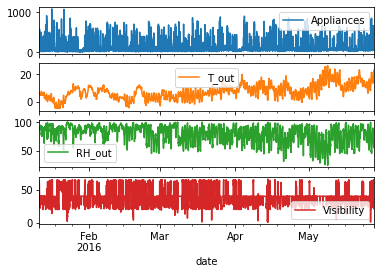

In [10]:
data.set_index('date')[['Appliances','T_out','RH_out','Visibility']].plot(subplots=True)

In [11]:
input = data[['Appliances','T_out','RH_out','Visibility']]
input.head()

,Appliances,T_out,RH_out,Visibility
0,60,6.600000,92.0,63.000000
1,60,6.483333,92.0,59.166667
2,50,6.366667,92.0,55.333333
3,50,6.250000,92.0,51.500000
4,60,6.133333,92.0,47.666667


In [40]:
input.tail()

,Appliances,T_out,RH_out,Visibility
19730,100,22.733333,55.666667,23.666667
19731,90,22.600000,56.000000,24.500000
19732,270,22.466667,56.333333,25.333333
19733,420,22.333333,56.666667,26.166667
19734,430,22.200000,57.000000,27.000000


In [15]:
sca=MinMaxScaler()
sca_data = sca.fit_transform(input)

In [17]:
X=sca_data
Y=sca_data[:,0]

In [18]:
TimeseriesGenerator(X,Y,length=2,batch_size=1)[0]

(array([[[0.04672897, 0.37299035, 0.89473684, 0.95384615],
         [0.04672897, 0.36923901, 0.89473684, 0.89487179]]]),
 array([0.03738318]))

In [19]:
xtrain,xtest,ytrain,ytest=train_test_split(X,Y,random_state=0,shuffle=False)

In [20]:
win_length = 720
train_generator = TimeseriesGenerator(xtrain,ytrain, length=win_length,batch_size=32) 
test_generator = TimeseriesGenerator(xtest,ytest, length=win_length,batch_size=32) 

In [21]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [28]:
model=Sequential()
model.add(LSTM(32, input_shape=(win_length,4),activation='tanh',return_sequences=True))
model.add(LSTM(512, activation='tanh',return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(1024, activation='tanh',return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(1024, activation='tanh',return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='tanh',return_sequences=False))
model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 720, 32)           4736      
                                                                 
 lstm_6 (LSTM)               (None, 720, 512)          1116160   
                                                                 
 dropout_3 (Dropout)         (None, 720, 512)          0         
                                                                 
 lstm_7 (LSTM)               (None, 720, 1024)         6295552   
                                                                 
 dropout_4 (Dropout)         (None, 720, 1024)         0         
                                                                 
 lstm_8 (LSTM)               (None, 720, 1024)         8392704   
                                                                 
 dropout_5 (Dropout)         (None, 720, 1024)        

In [29]:
import keras
model.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(),metrics=[keras.metrics.MeanAbsoluteError()])

In [30]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,mode='min',verbose=1)

In [31]:
from keras import callbacks
hist=model.fit_generator(train_generator,epochs=1,validation_data=test_generator,shuffle=False,callbacks=[early_stopping])

<ipython-input-31-737279b87faa>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=model.fit_generator(train_generator,epochs=1,validation_data=test_generator,shuffle=False,callbacks=[early_stopping])


441/441 [==============================] - 455s 1s/step - loss: 0.0175 - mean_absolute_error: 0.0626 - val_loss: 0.0100 - val_mean_absolute_error: 0.0820


In [32]:
model.evaluate(test_generator)

132/132 [==============================] - 46s 350ms/step - loss: 0.0100 - mean_absolute_error: 0.0820


[0.009967866353690624, 0.08201917260885239]

In [33]:
pred=model.predict(test_generator)

132/132 [==============================] - 47s 337ms/step


In [34]:
print(xtest.shape)
print(pred.shape)

(4934, 4)
(4214, 1)


In [35]:
df_pred=pd.concat([pd.DataFrame(pred),pd.DataFrame(xtest[:,1:][win_length:])],axis=1)

In [36]:
df_pred.shape

(4214, 4)

In [37]:
inv_data=sca.inverse_transform(df_pred)

In [39]:
inv_data

array([[127.84640737,   7.55833333,  66.08333333,  40.        ],
       [127.99634703,   7.7       ,  65.        ,  40.        ],
       [128.12193185,   7.23333333,  66.83333333,  40.        ],
       ...,
       [225.43098301,  22.46666667,  56.33333333,  25.33333333],
       [226.86996683,  22.33333333,  56.66666667,  26.16666667],
       [228.79105672,  22.2       ,  57.        ,  27.        ]])

In [42]:
df_final = input[pred.shape[0]*-1:]

In [43]:
df_final

,Appliances,T_out,RH_out,Visibility
15521,50,7.558333,66.083333,40.000000
15522,60,7.700000,65.000000,40.000000
15523,50,7.233333,66.833333,40.000000
15524,30,6.766667,68.666667,40.000000
15525,30,6.300000,70.500000,40.000000
...,...,...,...,...
19730,100,22.733333,55.666667,23.666667
19731,90,22.600000,56.000000,24.500000
19732,270,22.466667,56.333333,25.333333
19733,420,22.333333,56.666667,26.166667


In [44]:
df_final['pred_appli']=inv_data[:,0]

<ipython-input-44-fcc1cc9cdcba>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['pred_appli']=inv_data[:,0]


In [45]:
df_final.head()

,Appliances,T_out,RH_out,Visibility,pred_appli
15521,50,7.558333,66.083333,40.0,127.846407
15522,60,7.700000,65.000000,40.0,127.996347
15523,50,7.233333,66.833333,40.0,128.121932
15524,30,6.766667,68.666667,40.0,128.157153
15525,30,6.300000,70.500000,40.0,128.049960


<Axes: >

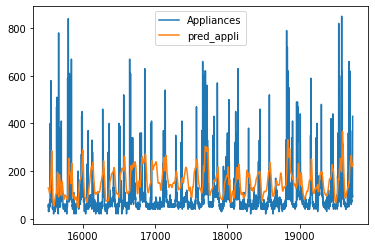

In [48]:
df_final[['Appliances','pred_appli']].plot()